In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib qt

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
# import pandas as pd
# pd.options.display.width = 1000

from vrAnalysis import analysis
from vrAnalysis import helpers
from vrAnalysis import database
from vrAnalysis import tracking

# from vrAnalysis.uiDatabase import addEntryGUI
# from vrAnalysis.redgui import redCellGUI as rgui

sessiondb = database.vrDatabase('vrSessions')
mousedb = database.vrDatabase('vrMice')

# pd.set_option('display.max_rows', 100)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

In [ ]:
# Analyses and work to do:

# ROICaT Figure:
# - in example.py, continue building interactive viewer, need to speed up spkmap loading (by preallocating instead of using _make_data method)
# - build an example figure with the ROICaT data (can be simple, just make it soon)

# LBM-s3d:
# - get started

In [2]:
# Database Management:
# I need a way to report how many sessions the mouse has experienced each environment, independent of 
# which environments are represented in imaging sessions (which is how I'm doing it now...)

# Required Updates: 
# need to update the placeCellMultiSession object to reflect changes to spkmap code
# anything that uses pcss.get_place_field (pcmm make_snake_data and make_paired_snake)

# Compare cvPCA analyses with eigenspectrum of spontaneous data unrelated to SVCA
# And I want to start with the rastermap on projected place field data

# Compare cvPCA to SVCA (do a hybrid: use cvPCA to get the spatial PCs, then apply those to the SVCA split)

# Buzsaki Data:
# https://crcns.org/data-sets/hc/hc-3 -- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4097350/
# https://app.globus.org/file-manager?origin_id=188a6110-96db-11eb-b7a9-f57b2d55370d&origin_path=%2FVargaV%2F&two_pane=false - https://buzsakilab.com/wp/animals/?frm_search&project=67125&frm-page-14333=2

In [1]:
# Post Dataclub 240429: 
# -- need to consolidate all my figures (especially for the last few slides in a script)

In [3]:
# Post Meeting with Kenneth Plan:
# - Relate to Kernel Matrices:
#   - https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c09_p291-326.pdf
#   - First, look at the kernel matrices (the position x position covariance matrices for each environment/session)
#   - Study the structure, and how it changes over time. 
#   - Compare the cross-validated kernel and the non-cv kernel matrix and compare their changes over time
#            - notes about ^^, this will tell us how much changes in eigenspectrum relate to reliability across trials vs the shape of the kernel matrix etc...
# - Studies of non-place cells:
#   - Look at the eigenspectrum from non-place cells, suppose as a function of the reliability...
#   - Do cross-validated decoding from non-place cells
# - Discussion of SVCA results
#   - SVCA dimensionality could have issues with noise estimation... the same way the trial expanded cvPCA plots did...
#   - Predict cell2 group from cell1 group, and predict cell2 group from their cross-validated place field, compare variance explained and overlap in variance explained
# - Rastermap: 
#   - need to find a way to remove expected spatial activity from full spike trace data (then maybe do rastermap again?)
# - Signal to Noise
#   - For each ROI, measure activity in center of place field, outside of place field on a linear track, and outside the track (or in other environments)
# - Measure spontaneous periods of activity.

In [4]:
#   cdata = sum_func(spectra_data[cvar][j][eidx])
# Warning: all_pf_tdot_cv is all nan for ATL027 3 13
# Warning: all_pf_tdot_cv is all nan for ATL012 3 18
# Warning: all_pf_tdot_cv is all nan for ATL012 3 20
# C:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
#   var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
# Warning: all_pf_tdot_cv is all nan for ATL027 3 13
# Warning: all_pf_tdot_cv is all nan for ATL012 3 18
# Warning: all_pf_tdot_cv is all nan for ATL012 3 20
# Backend QtAgg is interactive backend. Turning interactive mode on.

In [11]:
# load spectra data for target mouse
mouse_name = "ATL027"
track = tracking.tracker(mouse_name)  # get tracker object for mouse
pcm = analysis.placeCellMultiSession(track, autoload=False)  # open up place cell multi session analysis object (don't autoload!!!)
mouse_env_order = helpers.get_env_order(mousedb, mouse_name)

# load spectra data (use temp if it matches)
args = helpers.AttributeDict(
    dict(
        mouse_name=mouse_name,
        dist_step=1,
        smooth=0.1,
        cutoffs=(0.4, 0.7),
        maxcutoffs=None,
        reload_spectra_data=False,
    )
)

spectra_data = analysis.variance_structure.load_spectra_data(pcm, args, save_as_temp=True, reload=False)

Successfully loaded temporary data for variance structure analysis.


In [ ]:
# do this with a comparison of cells with nearby tuning!!!

# compare the above for high PF variance neurons and low PF variance 
# neurons (both with "reliable" PFs)

In [ ]:
# ROICaT Figure -- Example

# Goal: show FOV from two sessions, with matched nearby ROIs color-coded the same way and non-tracked but nearby ROIs color-coded differently
# Pick ROIs that have a good place field
# Show trial by position heat maps stacked by session color-coded the same way as the ROI to show that tracked has the same place field and non-tracked (but close) doesn't

mouse_name = 'ATL027'
track = tracking.tracker(mouse_name)
roistat = analysis.RoicatStats(track)

In [ ]:
# processing methods for preloaded roistat object
envnum = roistat.env_selector(envmethod="most")

# get all sessions with chosen environment
idx_ses = roistat.idx_ses_selector(envnum, sesmethod="all")

# pick 4 environments, the later the better, but if there's lots of sessions don't do the last one (imaging quality dropped off in last couple sessions usually)
if len(idx_ses) > 7:
    idx_ses = idx_ses[-6:-2]
elif len(idx_ses) > 4:
    idx_ses = idx_ses[-4:]

# report which environment and sessions are being used
print("env:", envnum, "idx_ses:", idx_ses)

# get data for all roicat plots

kwargs = dict(
    sim_name="sConj",
    cutoffs=(0.6, 0.85),
    both_reliable=False,
)

sim, corr, tracked, pwdist, nnpair, pwind, prms = roistat.make_roicat_comparison(envnum, idx_ses=idx_ses, **kwargs)
centroids = roistat.track.get_centroids(idx_ses=prms['idx_ses'], cat_planes=True, combine=True, keep_planes=roistat.keep_planes)

env: 3 idx_ses: [8, 9, 10, 11]


  0%|          | 0/4 [00:00<?, ?it/s]

getting roi data: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]
c:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\analysis\roicat_stats.py:159: RuntimeWarning: All-NaN slice encountered
  nn_dist = [np.nanmin(pwd, axis=1) for pwd in pwdists]
getting roi data: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [ ]:
def check_no_duplicates(roi_idx_match, roi_idx_nomatch):
    no_duplicates = []
    for im, inm in zip(roi_idx_match, roi_idx_nomatch):
        c_duplicates = im.reshape(2, -1, 1) == inm.reshape(2, 1, -1)
        no_duplicates.append(~np.any(c_duplicates, axis=0))
    return no_duplicates

def get_centroids_match(centroids, idx, prms):
    assert len(prms['idx_ses_pairs'])==len(idx), "idx doesn't match number of session pairs" 
    assert len(centroids)==len(prms['idx_ses']), "centroids doesn't match number of sessions"
    
    # prepare lookup table for going from the absolute session index to the relative index in centroids
    session_lookup = lambda ises: {val: idx for idx, val in enumerate(prms['idx_ses'])}[ises]
    
    # prepare list for centroids of matched pairs
    centroids_matched = []
    for ipair, imatch in zip(prms['idx_ses_pairs'], idx):
        i1 = session_lookup(ipair[0]) # idx to first session in pair
        i2 = session_lookup(ipair[1]) # idx to second session in pair
        c1 = centroids[i1][imatch[0]] # centroids in first session
        c2 = centroids[i2][imatch[1]] # centroids in second session
        centroids_matched.append(np.stack((c1, c2)))

    return centroids_matched

def get_plane_of_pair(roistat, idx, prms):
    assert len(idx)==len(prms['idx_ses_pairs']), "idx and prms['idx_ses_pairs'] don't have same number of elements"

    # prepare lookup table for going from the absolute session index to the relative index in centroids
    session_lookup = lambda ises: {val: idx for idx, val in enumerate(prms['idx_ses'])}[ises]

    # get plane index for each roi from sessions
    roiPlaneIdx = roistat.get_from_pcss('roiPlaneIdx', prms['idx_ses'])

    # prepare list of roi plane index for each pair
    pair_plane = []
    for ipair, ii in zip(prms['idx_ses_pairs'], idx):
        i1 = session_lookup(ipair[0])
        i2 = session_lookup(ipair[1])
        pp1 = roiPlaneIdx[i1][ii[0]]
        pp2 = roiPlaneIdx[i2][ii[1]]
        if not np.all(pp1==pp2): 
            raise ValueError("Planes of pair don't all match")
        pair_plane.append(pp1)
    
    return pair_plane


# set parameters for possible pairs
mincorr = 0.8 # minimum correlation for matched pair
maxcorr = 0.2 # maximum correlation for non-matched pair
maxdist = 6 # maximum distance for any example pair

# set parameters for pair of pairs (distance apart etc.)
maxdistpp = 12 # maximum distance for pair of pairs
mindistpp = 6 # minimum distance for pair of pairs

# get possible matches and not-matches
idx_possible_match = [np.where(t & (c>mincorr) & (pwd<maxdist))[0] for t, c, pwd in zip(tracked, corr, pwdist)] 
idx_possible_nomatch = [np.where(~t & (c<maxcorr) & (pwd<maxdist))[0] for t, c, pwd in zip(tracked, corr, pwdist)]

# get possible match/nomatch pair indices
roi_idx_match = [pwi[:, i] for pwi, i in zip(pwind, idx_possible_match)]
roi_idx_nomatch = [pwi[:, i] for pwi, i in zip(pwind, idx_possible_nomatch)]

# get average centroid of pairs
centroids_match = get_centroids_match(centroids, roi_idx_match, prms)
centroids_nomatch = get_centroids_match(centroids, roi_idx_nomatch, prms)
acentroid_match = [np.mean(c, axis=0) for c in centroids_match]
acentroid_nomatch = [np.mean(c, axis=0) for c in centroids_nomatch]

# get distance between pairs of possible match/nomatch for each pair of sessions
dist_match_nomatch = [sp.spatial.distance.cdist(am, anm) for am, anm in zip(acentroid_match, acentroid_nomatch)]
good_distance = [(dmn<maxdistpp) & (dmn>mindistpp) for dmn in dist_match_nomatch]

# check if pairs include any of the same ROIs
no_duplicates = check_no_duplicates(roi_idx_match, roi_idx_nomatch)

# get plane indices for each pair
plane_pair_match = get_plane_of_pair(roistat, roi_idx_match, prms)
plane_pair_nomatch = get_plane_of_pair(roistat, roi_idx_nomatch, prms)
same_plane = [ppm.reshape(-1, 1) == ppn.reshape(1, -1) for ppm, ppn in zip(plane_pair_match, plane_pair_nomatch)]

# possible pair of pairs boolean array
ipair_match, ipair_nomatch = helpers.named_transpose([np.where(gd & nd & smp) for gd, nd, smp in zip(good_distance, no_duplicates, same_plane)])

# indices to ROI pairs for good pairs of pairs
pp_roi_match = [rim[:, ipm] for rim, ipm in zip(roi_idx_match, ipair_match)]
pp_roi_nomatch = [rinm[:, ipnm] for rinm, ipnm in zip(roi_idx_nomatch, ipair_nomatch)] 
pp_centroid_match = [acm[ipm] for acm, ipm in zip(acentroid_match, ipair_match)]
pp_centroid_nomatch = [acnm[ipnm] for acnm, ipnm in zip(acentroid_nomatch, ipair_nomatch)]

# get plane indices for each pair
plane_pair = get_plane_of_pair(roistat, pp_roi_match, prms)

# check that match and no-match pairs are in same plane
assert all([np.all(pp==ppnm) for pp, ppnm in zip(plane_pair, get_plane_of_pair(roistat, pp_roi_nomatch, prms))])

# this lists the shapes of pairs of ROI indices across the session pairs for pairs of pairs =<
print([i.shape for i in pp_roi_match])
print([i.shape for i in pp_roi_nomatch])
print([i.shape for i in pp_centroid_match])
print([i.shape for i in pp_centroid_nomatch])

[(2, 70), (2, 63), (2, 52), (2, 88), (2, 85), (2, 169)]
[(2, 70), (2, 63), (2, 52), (2, 88), (2, 85), (2, 169)]
[(70, 2), (63, 2), (52, 2), (88, 2), (85, 2), (169, 2)]
[(70, 2), (63, 2), (52, 2), (88, 2), (85, 2), (169, 2)]


In [ ]:
# Now make figures
def get_masks(roistat, isespair, idxroipair, prms, pp_roi_match, pp_roi_nomatch):
    ROIs = roistat.track.get_ROIs(as_coo=False, idx_ses=prms['idx_ses_pairs'][isespair], keep_planes=roistat.keep_planes)
    ROIs = [sp.sparse.vstack(rois, format='csr') for rois in ROIs] # concatenate across planes

    roi_match = [ROIs[0][pp_roi_match[isespair][0, idxroipair]], ROIs[1][pp_roi_match[isespair][1, idxroipair]]]
    roi_nomatch = [ROIs[0][pp_roi_nomatch[isespair][0, idxroipair]], ROIs[1][pp_roi_nomatch[isespair][1, idxroipair]]]

    num_pixels = roi_match[0].shape[1]
    hw = int(np.sqrt(num_pixels))
    roi_match = [r.toarray().reshape(hw, hw) for r in roi_match]
    roi_nomatch = [r.toarray().reshape(hw, hw) for r in roi_nomatch]

    return roi_match, roi_nomatch

def get_spkmaps(roistat, isespair, idxroipair, prms, pp_roi_match, pp_roi_nomatch):
    spkmaps = roistat.get_spkmaps(envnum, trials="full", average=False, tracked=False, idx_ses=prms['idx_ses_pairs'][isespair], by_plane=False)[0]
    spkmap_match = [spkmaps[0][pp_roi_match[isespair][0, idxroipair]], spkmaps[1][pp_roi_match[isespair][1, idxroipair]]]
    spkmap_nomatch = [spkmaps[0][pp_roi_nomatch[isespair][0, idxroipair]], spkmaps[1][pp_roi_nomatch[isespair][1, idxroipair]]]
    spkmap_match = [sp.stats.zscore(sm, axis=None) for sm in spkmap_match]
    spkmap_nomatch = [sp.stats.zscore(sm, axis=None) for sm in spkmap_nomatch]
    distedges = roistat.pcss[prms['idx_ses_pairs'][isespair][0]].distedges
    return spkmap_match, spkmap_nomatch, distedges

# pick random session pair and random index
isespair = 0
idxroipair = np.random.choice(pp_roi_match[isespair].shape[1])
roi_scale = 2.5
lim = 3 # zscore limit of colormap
print('Session Pair:', prms['idx_ses_pairs'][isespair], "ROI Pair:", idxroipair)
print("Match Idx:", pp_roi_match[isespair][:, idxroipair], "NoMatch Idx:", pp_roi_nomatch[isespair][:, idxroipair])

ccpair = np.mean(np.stack((pp_centroid_match[isespair][idxroipair], pp_centroid_nomatch[isespair][idxroipair])), axis=0)

spkmaps_match, spkmaps_nomatch, distedges = get_spkmaps(roistat, isespair, idxroipair, prms, pp_roi_match, pp_roi_nomatch)
extents = [[0, sm.shape[0], distedges[0], distedges[-1]] for sm in spkmaps_match]

# make heatmaps of FOV
FOVs = [roistat.track.rundata[plane_pair[isespair][idxroipair]]["aligner"]["ims_registered_nonrigid"][i] for i in prms['idx_ses_pairs'][isespair]]
roi_match, roi_nomatch = get_masks(roistat, isespair, idxroipair, prms, pp_roi_match, pp_roi_nomatch)
normalize = lambda data: [((d-d.min())/(d.max()-d.min())).astype(np.float32) for d in data]
FOVs = normalize(FOVs)
roi_match = normalize(roi_match)
roi_nomatch = normalize(roi_nomatch)

fov_plot = [np.tile(fov.reshape(fov.shape[0], fov.shape[1], 1), (1, 1, 3)) for fov in FOVs]
fov_plot[0][:, :, 0] += roi_match[0]*roi_scale
fov_plot[1][:, :, 0] += roi_match[1]*roi_scale
fov_plot[0][:, :, 1] += roi_nomatch[0]*roi_scale
fov_plot[1][:, :, 2] += roi_nomatch[1]*roi_scale
fov_plot = normalize(fov_plot)


fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout='constrained', sharex=True, sharey=True)
ax[0].imshow(fov_plot[0])
ax[1].imshow(fov_plot[1])
ax[0].set_xlim(ccpair[0] + [-20, 20])
ax[0].set_ylim(ccpair[1] + [-20, 20])
ax[0].set_title('Session 1')
ax[1].set_title('Session 2')
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(6, 6), layout='constrained', sharey=True)
ax[0, 0].imshow(spkmaps_match[0].T, cmap='Reds', aspect='auto', extent=extents[0], vmin=0, vmax=lim)
ax[0, 1].imshow(spkmaps_match[1].T, cmap='Reds', aspect='auto', extent=extents[1], vmin=0, vmax=lim)
ax[1, 0].imshow(spkmaps_nomatch[0].T, cmap='Greens', aspect='auto', extent=extents[0], vmin=0, vmax=lim)
ax[1, 1].imshow(spkmaps_nomatch[1].T, cmap='Blues', aspect='auto', extent=extents[1], vmin=0, vmax=lim)
ax[0, 0].set_ylabel("Virtual Position (cm)")
ax[1, 0].set_ylabel("Virtual Position (cm)")
ax[1, 0].set_xlabel('Trials')
ax[1, 1].set_xlabel('Trials')
ax[0, 0].set_title('Session 1')
ax[0, 1].set_title('Session 2')
plt.show()

Session Pair: [8 9] ROI Pair: 39
Match Idx: [10633  7025] NoMatch Idx: [9804 7771]


In [ ]:
pp_roi_match[0].shape

(2, 18)

In [ ]:
mouse_name = 'ATL027'
track = tracking.tracker(mouse_name)
pcm = analysis.placeCellMultiSession(track)

In [ ]:
env, idx_ses = pcm.env_idx_ses_selector(envmethod='most', sesmethod=-6, verbose=True)

distStep = 1
out = pcm.get_spkmaps(env, trials='full', average=False, tracked=False, pf_method='max', by_plane=False, idx_ses=idx_ses, distStep=distStep, full_trial_flexibility=2.5)
spkmaps, relmse, relcor, pfloc, pfidx, idx_red, roi_idx = out
idx_with_nan = [np.any(np.isnan(s), axis=(0, 1)) for s in spkmaps]
idx_with_nan_across_spkmaps = np.any(np.stack(idx_with_nan), axis=0)
spkmaps = [spkmap[:, :, ~idx_with_nan_across_spkmaps] for spkmap in spkmaps]

cutoffs = (0.2, 0.5)
idx_reliable = [[(mse>cutoffs[0]) & (cor>cutoffs[1]) for mse, cor in zip(rmse, rcor)] for rmse, rcor in zip(relmse, relcor)]
spkmaps = [spkmap[idx] for spkmap, idx in zip(spkmaps, idx_reliable)]
print('spkmap shape', [s.shape for s in spkmaps])

max_trials = int(min([sm.shape[1] for sm in spkmaps])/2)
max_neurons = int(min([sm.shape[0] for sm in spkmaps])/2)

ATL027 Env (most): 3, Sessions (-6): [8, 9, 10, 11, 12, 13]


 50%|█████     | 3/6 [00:20<00:19,  6.47s/it]c:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\functions.py:208: RuntimeWarning: overflow encountered in divide
  relmse[idxHasActivity] += 1 - numerator[idxHasActivity] / denominator[idxHasActivity]
100%|██████████| 6/6 [00:41<00:00,  6.92s/it]


AttributeError: 'placeCellMultiSession' object has no attribute 'smooth'

In [ ]:
cvmethods = [cvPCA_from_MouseLandGithub, cvPCA_paper_stimuli, cvPCA_paper_neurons]
w_git, w_stim, w_neur = helpers.named_transpose([cvpca(spkmap, by_trial=False, max_trials=max_trials, max_neurons=max_neurons, cvmethods=cvmethods) for spkmap in spkmaps])
wns_git, wns_stim, wns_neur = helpers.named_transpose([cvpca(spkmap, by_trial=False, max_trials=max_trials, max_neurons=max_neurons, nshuff=1, cvmethods=cvmethods) for spkmap in spkmaps])

wt_git, wt_stim, wt_neur = helpers.named_transpose([cvpca(spkmap, by_trial=True, noise_corr=False, max_trials=max_trials, max_neurons=max_neurons, cvmethods=cvmethods) for spkmap in spkmaps])
wtnc_git, wtnc_stim, wtnc_neur = helpers.named_transpose([cvpca(spkmap, by_trial=True, noise_corr=True, max_trials=max_trials, max_neurons=max_neurons, cvmethods=cvmethods) for spkmap in spkmaps])

In [ ]:
# To compare shuffled with no shuffled
num_sessions = len(w_git)
fig, ax = plt.subplots(1, num_sessions, figsize=(num_sessions*2, 2), layout='constrained')
for ii, (w, wns) in enumerate(zip(w_neur, wns_neur)):
    ax[ii].plot(w / np.sum(w), color='k', label='ShuffledAverage')
    ax[ii].plot(wns / np.sum(wns), color='r', label='No Shuffle')
    ax[ii].set_xscale('log')
ax[-1].legend(loc='best')
plt.show()

In [ ]:
# To compare no average with and without noise-correlation
num_sessions = len(w_git)
fig, ax = plt.subplots(1, num_sessions, figsize=(num_sessions*2, 2), layout='constrained', sharey=True)
for ii, (w, wns) in enumerate(zip(wt_neur, wtnc_neur)):
    ax[ii].plot(w / np.sum(w), color='k', label='No Noise-Corr')
    ax[ii].plot(wns / np.sum(wns), color='r', label='Only Noise-Corr')
    ax[ii].set_xscale('log')
ax[-1].legend(loc='best')
plt.show()

In [ ]:
# To compare three different cvPCA methods
num_sessions = len(w_git)
fig, ax = plt.subplots(2, num_sessions, figsize=(num_sessions*2, 4), layout='constrained')
for ii, (wg, ws, wn) in enumerate(zip(w_git, w_stim, w_neur)):
    ax[0, ii].plot(wg, color='k', label='FromGithub')
    ax[0, ii].plot(ws + 0.01, color='r', label='FromPaper-Stimuli')
    ax[0, ii].plot(wn + 0.02, color='b', label='FromPaper-Neurons')
    ax[0, ii].set_xscale('log')

    ax[1, ii].plot(wg / np.sum(wg), color='k', label='FromGithub')
    ax[1, ii].plot(ws / np.sum(ws), color='r', label='FromPaper-Stimuli')
    ax[1, ii].plot(wn / np.sum(wn), color='b', label='FromPaper-Neurons')
    ax[1, ii].set_xscale('log')
plt.show()

In [ ]:
# To compare averaged vs all trials
cmap = mpl.colormaps['bwr'].resampled(len(spkmaps))

plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout='constrained')
for ii, (wa, wt) in enumerate(zip(w_neur, wt_neur)):
    ax[0].plot(np.cumsum(wa / np.sum(wa)), color=cmap(ii))
    ax[1].plot(np.cumsum(wt / np.sum(wt)), color=cmap(ii))
    if ii==0:
        ax[2].plot(np.cumsum(wa / np.sum(wa)), color='k', label='Averaged')
        ax[2].plot(np.cumsum(wt / np.sum(wt)), color='b', label='Expanded')
    else:
        ax[2].plot(np.cumsum(wa / np.sum(wa)), color='k')
        ax[2].plot(np.cumsum(wt / np.sum(wt)), color='b')
    
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
ax[0].set_title('Average Across Trials')
ax[1].set_title('Expanded Across Trials')
ax[2].set_title('Comparison')
ax[2].legend(loc='best')
plt.show()

In [ ]:
fm.s2pTargets('ATL045', '2024-02-02', '702')

\\zaru.cortexlab.net\Subjects\ATL045\2024-02-02\702
C:\Users\andrew\Documents\localData\ATL045\2024-02-02\702


In [ ]:
sessiondb.registerSessions(maxData=50e9, skipErrors=False)


Performing vrExperiment preprocessing for session: ATL045/2024-01-24/701
Cleared oneData from session: ATL045/2024-01-24/701
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
Performing oasis...


100%|██████████| 18509/18509 [07:30<00:00, 41.05it/s]


Computing red cell features for ATL045/2024-01-24/701... (usually takes 10-20 seconds)
Facecam preprocessing has not been coded yet!
Saving params...
Session ATL045/2024-01-24/701 registered with 4.75 GB oneData.
Accumulated oneData registered: 4.75 GB. Averaging: 4.75 GB / session. Estimate remaining: 9.49 GB

Performing vrExperiment preprocessing for session: ATL045/2024-01-26/701
Cleared oneData from session: ATL045/2024-01-26/701
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
frame2time had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame
Performing oasis...


100%|██████████| 13986/13986 [06:08<00:00, 37.91it/s]


Computing red cell features for ATL045/2024-01-26/701... (usually takes 10-20 seconds)
Facecam preprocessing has not been coded yet!
Saving params...
Session ATL045/2024-01-26/701 registered with 3.88 GB oneData.
Accumulated oneData registered: 8.63 GB. Averaging: 4.32 GB / session. Estimate remaining: 4.32 GB


In [ ]:
sessiondb.needsS2P()
# sessiondb.checkS2P(withDatabaseUpdate=True, returnCheck=False)

,uSessionID,mouseName,sessionDate,sessionID,experimentType,experimentID,variableGain,behavior,imaging,faceCamera,...,scratchJustification,logtime,sessionNotes,suite2pDate,vrRegistrationDate,vrRegistrationError,vrRegistrationException,redCellQCDate,vrBehaviorVersion,dontTrack


In [ ]:
# session identifiers
mouseName = 'ATL045'
sessionDate = '2024-02-02'
sessionID = '702'

# create session object 
# (at the moment, this only provides mouseName, sessionDate, and sessionID to the GUI, but will increase later)
ses = registration.vrRegistration(mouseName, sessionDate, sessionID)

# preloaded data
preloaded_data = {
    'experimentType': 'Blender VR',
    'experimentID': 2,
    'variableGain': True,
    'behavior': True,
    'imaging': True, 
    'faceCamera': True, 
    'vrEnvironments': 12,
    'numPlanes': 5,
    'planeSeparation': 25,
    'suite2p': False,
    'vrBehaviorVersion': 1,
    'headPlateRotation': 5.9,
    'objectiveRotation': 7.7,
    'pockelsPercentage': 4,
    'dontTrack': False,
    'sessionNotes': (
        "FOV is different from yesterday."
    )
}

# then open the GUI
gui = addEntryGUI.newEntryGUI(sessiondb, ses=ses, **preloaded_data)

This could be coded smarter with already calling checkValidity()
Successfully added new record


In [ ]:
import datetime
date = datetime.datetime(2024, 1, 24, 0, 0)
print(isinstance(date, datetime.date))

True


In [ ]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update

# Further Requirements:
# ---------------------
# ROICaT Alignment Tools 
# Track Red Cell Consistency across days 
# Now that I've refactored the database code, need to update some things in documentation and probably elsewhere too


In [ ]:
# Notes from meeting with Kenneth:

# - skewness (violin plot) of Control & Red -- 
#     - all - 
#     - just reliable -- for each session - 

# Subsample control data for scatter plot
# Fisher z transformation (but label by original correlation...)
# Question:
# -- if reliable on 1 day, is it reliable on other days? 
# -- make a matrix with source and target, color by fraction of reliable on target out of those reliable on source
# -- also do this with your session kernels for control and red
# -- also do this for different reliability cutoffs

In [ ]:
# Plan for attack:
# Make a suite of summary figures on a session by session basis and a multisession basis. 
# I just want to be able to look through a mouse's data and evaluate the behavior, the imaging data, and how well the tracking did.

# Inclusions:
# 1. Behavioral data (running speed and number of trials across any environments it was in -- also metadata about day in environment...)
# 2. Imaging data (example snakes from all environments, both train/test comparisons and remapping comparisons)
# 3. Red cell data (number of red cells per plane -- and some examples of red cells?)
# 4. Tracking data (number of tracked cells per combination (full matrix!), number of tracked red cells, number of tracked reliable cells per environment)

In [ ]:
# ROICaT Analysis
# 1. Example data figures (from roicat_stats)
#    - show two post-alignment FOVs, highlight a few tracked neurons and a few (nearby) un-tracked neurons with colors
#    - below that, show the place field tuning in each session, color-coded the same way as the neurons ROI plot

# 2. Analysis of ROICaT agreement with functional data
#    - scatter plot of sConj & place field correlation (with "labels" pairs colored differently)
#    - mouse by mouse, session by session mean lines comparing average place field correlation of same pairs with different pairs
#        -- (imagining lines from 0->1 for mouse 1 of each sessions mean same/diff pfCorr, then also in 2->3 for mouse 2, and 4->5 for mouse 3, etc.)
#        -- can also have a supplemental plot showing distribution of same/diff pfCorr across each session pair? 

# 3. Control analysis with null model test (empirical version with subsampled null distribution)

# 4. Control analysis with bayesian model
# -- get pfCorr_withinSession (this is pairs of ROIs within a session, and should be representative of pfCorr_diff_acrossSession)
# -- normalize pfCorr_all_acrossSession by number of pairs, subtract density of pfCorr_withinSession
# -- remaining pfCorr_remain_acrossSession = pfCorr_same_acrossSession


# ---- note ----
# - should probably include target reliable pairs not represented in the source only reliable category...

In [ ]:
mouse_name = 'ATL027'
track = tracking.tracker(mouse_name)
roistat = analysis.RoicatStats(track)

In [ ]:
roistat.env_stats()

{1: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 4: [11, 12, 13]}

In [ ]:
env, idx_ses = roistat.env_idx_ses_selector(envmethod='most', sesmethod='all')
print(env, idx_ses)

3 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [ ]:
# get roicat comparison data
sim, corr, tracked, pwdist, nnpair, pwind, prms = roistat.make_roicat_comparison(env, idx_ses=idx_ses)

getting roi data: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
c:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\analysis\roicat_stats.py:100: RuntimeWarning: All-NaN slice encountered
  nn_dist = [np.nanmin(pwd, axis=1) for pwd in pwdists]


In [ ]:
plt.close('all')
# out = roistat.plot_pwdist_vs_pfcorr(pwdist, corr, tracked, prms, max_dist=50, color_mode='tracked', with_show=True, with_save=False)
# roistat.plot_pfcorr_by_samediff(corr, tracked, nnpair, prms, with_show=True, with_save=False)
roistat.plot_pfcorrmean_by_samediff(corr, tracked, nnpair, pwdist, prms, dist_limit=10, return_data=False, with_show=True, with_save=False)
# roistat.plot_pfcorr_vs_pwdist_by_group(corr, tracked, pwdist, nnpair, prms, with_show=True, with_save=False)

In [ ]:
fm.s2pTargets('ATL043', '2024-02-02', '701')

\\zaru.cortexlab.net\Subjects\ATL043\2024-02-02\701
C:\Users\andrew\Documents\localData\ATL043\2024-02-02\701


In [ ]:
TRACKED_MICE = mousedb.getTable(tracked=True)['mouseName'].tolist() # list of mice with tracked sessions

keep_planes = [1, 2, 3, 4]

kwargs = dict(
    sim_name='sConj',
    cutoffs=(0.4, 0.7),
    both_reliable=False,
)

# save means/serrors from pfcorr by classification test for across mouse plot of results
all_means = []
all_serrors = []

for mouse_name in TRACKED_MICE:
    print(f"Working on {mouse_name}...")
    track = tracking.tracker(mouse_name)
    roistat = analysis.RoicatStats(track, keep_planes=keep_planes)

    # select environment (CR mice had different structure and should use environment 2)
    if 'CR' in mouse_name:
        envnum = 2
    else:
        envnum = roistat.env_selector(envmethod='most')

    idx_ses = roistat.idx_ses_selector(envnum, sesmethod='all')
    
    if len(idx_ses)>7:
        idx_ses = idx_ses[-6:-2]
    elif len(idx_ses)>4:
        idx_ses = idx_ses[-4:]
    else:
        print(f'skipping {mouse_name}, because of the small sessions: {idx_ses}')
        continue

    print('env:', envnum, 'idx_ses:', idx_ses)
    
    # sim, corr, tracked, pwdist, nnpair, pwind, prms = roistat.make_roicat_comparison(envnum, idx_ses=idx_ses, **kwargs)
    # # roistat.plot_sim_vs_pfcorr(sim, corr, prms, color_mode='tracked', with_show=False, with_save=True)
    # # roistat.plot_pwdist_vs_pfcorr(pwdist, corr, tracked, prms, max_dist=50, color_mode='tracked', with_show=True, with_save=False)
    # # roistat.plot_pfcorr_by_samediff(corr, tracked, nnpair, prms, with_show=False, with_save=True)
    # c_means, c_serrors = roistat.plot_pfcorrmean_by_samediff(corr, tracked, nnpair, pwdist, prms, dist_limit=10, return_data=True, with_show=False, with_save=True)
    # # roistat.plot_similarity_histograms(sim, prms, with_show=False, with_save=True)
    # # roistat.plot_pfcorr_vs_pwdist_by_group(corr, tracked, pwdist, nnpair, prms, with_show=True, with_save=False)

    # all_means.append(c_means)
    # all_serrors.append(c_serrors)

    print('')

    plt.close('all')

Working on CR_Hippocannula6...
env: 2 idx_ses: [3, 4, 5, 6]

Working on CR_Hippocannula7...
env: 2 idx_ses: [3, 4, 5, 6]

Working on ATL022...
env: 3 idx_ses: [11, 12, 13, 14]

Working on ATL027...
env: 3 idx_ses: [8, 9, 10, 11]

Working on ATL020...
env: 3 idx_ses: [3, 4, 5, 6]

Working on ATL012...
env: 1 idx_ses: [18, 19, 20, 21]



In [ ]:
# Check ROICaT within session matching
import pickle

mouseName = 'ATL012'
sessionDate = '2023-02-28'
sessionID = '701'

ses = session.vrExperiment(mouseName, sessionDate, sessionID)
print(ses.sessionPrint())

data = ses.loadone('mpci.roiActivityDeconvolvedOasis')

filepath = ses.sessionPath() / f"{mouseName}.within_session.ROICaT.tracking.results.pkl"
with open(filepath, 'rb') as f:
    roicat = pickle.load(f)

num_clusters = np.max(roicat['clusters']['labels'])+1

ATL012/2023-02-28/701


In [ ]:
scc = analysis.sameCellCandidates(ses, keepPlanes=None)

In [ ]:
explorer = analysis.clusterExplorerROICaT(scc, roicat['clusters']['labels'], keepPlanes=None)

In [ ]:
cc_number = np.zeros(num_clusters)
cc_within = np.zeros(num_clusters)
for ic in range(num_clusters):
    cidx = roicat['clusters']['labels']==ic
    cdata = data[:, cidx]
    ccorr = np.corrcoef(cdata.T)
    idx_offdiag = np.triu(np.ones_like(ccorr, dtype=bool), k=1)
    cvals = ccorr[idx_offdiag]
    cc_within[ic] = np.mean(cvals)
    cc_number[ic] = np.sum(cidx)

plt.close('all')
plt.scatter(cc_number, cc_within)
plt.show()

In [ ]:
i_clus = np.random.randint(0, num_clusters)

plt.close('all')
plt.plot(range(data.shape[0]), data[:, roicat['clusters']['labels']==i_clus])
plt.show()

In [ ]:
np.sum(roicat['clusters']['labels']>-1)

815

In [ ]:
roicat

{'clusters': {'labels': array([-1,  0, -1, ..., -1, -1, -1], dtype=int64),
  'labels_bySession': [array([-1,  0, -1, ..., -1, -1, -1], dtype=int64),
   array([60, 20,  3, ..., -1, -1, -1], dtype=int64),
   array([ 91, 246,   3, ...,  -1,  -1,  -1], dtype=int64),
   array([  0, 175,  -1, ...,  -1,  -1,  -1], dtype=int64),
   array([111,  23,  -1, ...,  -1,  -1,  -1], dtype=int64)],
  'labels_bool': <7594x381 sparse matrix of type '<class 'numpy.bool_'>'
  	with 7594 stored elements in Compressed Sparse Row format>,
  'labels_bool_bySession': [<1458x381 sparse matrix of type '<class 'numpy.bool_'>'
   	with 1458 stored elements in Compressed Sparse Row format>,
   <1131x381 sparse matrix of type '<class 'numpy.bool_'>'
   	with 1131 stored elements in Compressed Sparse Row format>,
   <1410x381 sparse matrix of type '<class 'numpy.bool_'>'
   	with 1410 stored elements in Compressed Sparse Row format>,
   <1579x381 sparse matrix of type '<class 'numpy.bool_'>'
   	with 1579 stored elemen

In [ ]:
# ucids in list of lists for requested sessions
ucids = [[[] for _ in range(num_ses)] for _ in range(num_planes)]
for planeidx, results in enumerate([self.results[p] for p in keepPlanes]):
    for sesidx, idx in enumerate(idx_ses):
        ucids[planeidx][sesidx] = results['clusters']['labels_bySession'][idx]

# this is the number of unique IDs per plane
num_ucids = [max([np.max(u) for u in ucid])+1 for ucid in ucids]

# this is a boolean array of size (number unique IDs x num sessions) where there is a 1 if a unique ROI is found in each session
roicat_index = [np.zeros((nucids, num_ses), dtype=bool) for nucids in num_ucids]
for planeidx, ucid in enumerate(ucids):
    for sesidx, uc in enumerate(ucid):
        cindex = uc[uc >= 0] # index of ROIs found in this session
        roicat_index[planeidx][cindex, sesidx] = True # label found ROI with True

return ucids, roicat_index

    # get ucids and 1s index for requested sessions
    ucids, roicat_index = self.prepare_tracking_idx(idx_ses=idx_ses, keepPlanes=keepPlanes)
    
    # list of UCIDs in all requested sessions (a list of the UCIDs...)
    idx_in_ses = [np.where(np.all(rindex, axis=1))[0] for rindex in roicat_index]
    
    # For each plane & session, a sorted index to the suite2p ROI to recreate the list of UCIDs
    idx_to_ucid = [[helpers.index_in_target(iis, uc)[1] for uc in ucid] for (iis, ucid) in zip(idx_in_ses, ucids)]
    
    # cumulative number of ROIs before eacg plane (in numeric order of planes using sorted(self.plane_names))
    roi_per_plane = self.roi_per_plane[keepPlanes][:, idx_ses]
    roi_plane_offset = np.cumsum(np.vstack((np.zeros((1,num_ses),dtype=int), roi_per_plane[:-1])), axis=0)

    # A straightforward numpy array of (numSessions, numROIs) containing the indices to retrieve tracked and sorted ROIs
    return np.concatenate([np.stack([offset+ucid for offset, ucid in zip(offsets, ucids)], axis=1) for offsets, ucids in zip(roi_plane_offset, idx_to_ucid)], axis=0).T

In [ ]:
# Note: remove multipage tiff from: C:\Users\Andrew\Documents\localData\ATL012\2023-02-09\701\suite2p

In [ ]:
ises = sessiondb.iterSessions(imaging=True, experimentID=2, mouseName='ATL012')
ses = np.random.choice(ises)
print(ses.sessionPrint())

ATL012/2023-02-07/701


In [ ]:
ses = session.vrExperiment('ATL012', '2023-02-15', '701')
print(ses.sessionPrint())

ATL012/2023-02-15/701


In [ ]:
from PIL import Image

def save_ref_as_tiff(ses, image='meanImg_chan2'):
    ops = ses.loadS2P('ops')
    expected_shape = [(op['Ly'], op['Lx']) for op in ops]
    reference = [op[image] for op in ops]
    assert all([ref.shape==shape for ref, shape in zip(reference, expected_shape)]), f"shapes don't match, are you sure that {image} is an image?"
    ref_image = [Image.fromarray(ref) for ref in reference]
    for plane_name, im in zip(ses.value['planeNames'], ref_image):
        im.save(ses.suite2pPath() / f"{image}_{plane_name}.tif")
    return reference

reference = save_ref_as_tiff(ses)


In [ ]:
# Develop some code for behavioral analysis here!

In [ ]:
track = tracking.tracker('ATL012') # get tracker object for mouse
pcm = analysis.placeCellMultiSession(track, autoload=False) # open up place cell multi session analysis object (don't autoload!!!)

In [ ]:
cutoffs = (0.2, 0.5)
maxcutoffs = None

envs = pcm.environments[pcm.environments > 0]
print(envs)

for envnum in pcm.environments[pcm.environments > 0]:
    idx_ses = pcm.idx_ses_with_env(envnum)
    sortby = [idx_ses[i] for i in [1, int(len(idx_ses)*0.5), -1]]
    for sb in sortby:
        # pcm.plot_rel_comparison(envnum, idx_ses=None, sortby=sb, rel_method='pc', withShow=False, withSave=True)
        # pcm.plot_snake(envnum, idx_ses=None, sortby=sb, cutoffs=cutoffs, method='max', normalize=-80, rewzone=True, withShow=False, withSave=True)
        pass
    pcm.plot_pfplasticity(envnum, idx_ses=None, cutoffs=cutoffs, both_reliable=False, withShow=False, withSave=True)
    pcm.plot_pfplasticity(envnum, idx_ses=None, cutoffs=cutoffs, both_reliable=True, withShow=False, withSave=True)
    pcm.plot_pfreliability(envnum, idx_ses=None, cutoffs=None, reduction='median', withShow=False, withSave=True)
    pcm.compare_pfplasticity(envnum, idx_ses=None, cutoffs=cutoffs, both_reliable=False, withShow=False, withSave=True) 
    pcm.compare_pfplasticity(envnum, idx_ses=None, cutoffs=cutoffs, both_reliable=True, withShow=False, withSave=True) 
    pcm.plot_rel_plasticity(envnum, idx_ses=None, cutoffs=cutoffs, maxcutoffs=maxcutoffs, withShow=False, withSave=True)
    # for present in ['r2', 'pc']:
    #     pcm.hist_pfplasticity(envnum, idx_ses=None, cutoffs=cutoffs, present=present, split_red=True, withShow=False, withSave=True)

[1 3 4]


c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\lib\site-packages\scipy\stats\_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


ValueError: operands could not be broadcast together with shapes (0,40) (0,80) 

In [ ]:
pcm.plot_snake(3, cutoffs=(0.2, 0.5), withShow=True);

100%|██████████| 3/3 [00:45<00:00, 15.10s/it]


AssertionError: reward positions are not consistent: ([112.5, 162.5])

In [ ]:
plt.close('all')
pcm.plot_rel_comparison(1, idx_ses=None, sortby=8)

In [ ]:
idx_ses = pcm.idx_ses_with_env(3)
print(idx_ses)
sortby = [idx_ses[i] for i in [0, int(len(idx_ses)*0.5), -1]]
print(sortby)
        

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 13, 7]


In [ ]:
num_ses = len(skew)

offset = 0.2
ctl_positions = np.linspace(0, num_ses-1, num_ses) - offset
red_positions = np.linspace(0, num_ses-1, num_ses) + offset

plt.close('all')
cvp = plt.violinplot([s[~ir] for s, ir in zip(skew, idx_red)], ctl_positions)
rvp = plt.violinplot([s[ir] for s, ir in zip(skew, idx_red)], red_positions)
# for pc in cvp['bodies']: pc.set_color('k')
# for pc in rvp['bodies']: pc.set_color('r')
plt.show()

In [ ]:
x0 = np.random.normal(0,1,(10000,))
y0 = np.random.normal(0,1,(10000,)) + x0
x1 = np.random.normal(0,1,(10000,))-10
y1 = np.random.normal(0,1,(10000,)) - x1

all_x = np.concatenate((x0, x1))
all_y = np.concatenate((y0, y1))
extent = [all_x.min(), all_x.max(), all_y.min(), all_y.max()]
range = [[all_x.min(), all_x.max()], [all_y.min(), all_y.max()]]

num_bins = 25
H1, xe, ye = np.histogram2d(x1, y1, bins=num_bins, range=range)
H0, _, _ = np.histogram2d(x0, y0, bins=[xe,ye])
H_diff = H1.T - H0.T

extent = [xe.min(), xe.max(), ye.min(), ye.max()]
xc, yc = helpers.edge2center(xe), helpers.edge2center(ye)

# H_test = np.zeros((num_bins, num_bins))
# H_test[0,0]=1
# H_test[-1,0]=2
# H_test[0,-1]=3
# H_test[-1,-1]=4
# H_test = H_test.T
# print(H_test)

plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained', sharex=True, sharey=True)
sns.histplot(x=x0, y=y0, bins=[xe, ye], pthresh=0, cmap="Blues", ax=ax[0])
sns.histplot(x=x1, y=y1, bins=[xe, ye], pthresh=0, cmap="Blues", ax=ax[1])
plt.imshow(H_diff, interpolation=None, aspect='auto', origin='lower', extent=extent, cmap=sns.color_palette("icefire", as_cmap=True))
plt.show()

In [ ]:
# add methods to analysis documentation for pcm!!! (include explanation of idx_ses handling)

In [ ]:
# Now just need the skew plots and the reliability plots relative to other sessions

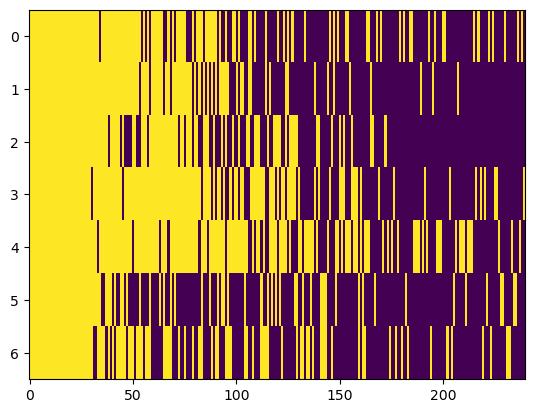

In [ ]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None, use_s2p=True)
idx_has_red = idx_red[:, np.any(idx_red, axis=0)]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()

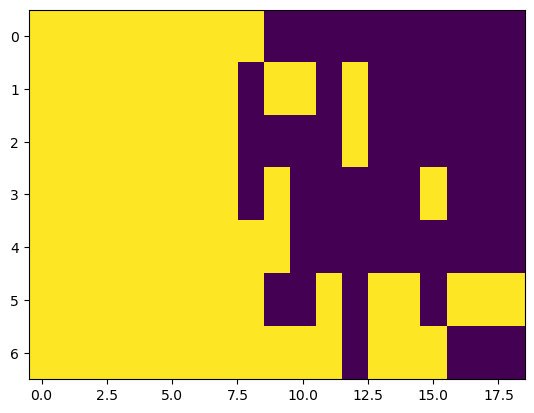

In [ ]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None)
idx_has_red = idx_red[:, np.sum(idx_red, axis=0)>0]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()